In [20]:
import tracesim_header
import tracesim_buffer
import tracesim_network
import tracesim_predictor
import headpred
import train_lstm_headsal
import tracesim_simulate
import tracesim_bandwidth
import tracesim_psnr
import test_simulator_lib
import pickle
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

reload(train_lstm_headsal)
reload(tracesim_network)
reload(tracesim_buffer)
reload(tracesim_predictor)
reload(tracesim_header)
reload(headpred)
reload(tracesim_simulate)
reload(tracesim_bandwidth)
reload(tracesim_psnr)
reload(test_simulator_lib)

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [21]:
bandwidth, delay = 2000000, 0.2# 8000000, 0.04
delay = 0.04
look_back = 8
look_ahead = 16
tilesize_map_template = './dat/tilesize_map_{}'
sds_path = tracesim_header.FILE_PATH_SDS
model_lstm_path = './models/lstm_128128_lookahead{}_full_epo2000_newratio'
bwtrace_path = './4G_log/report_bus_0004.log'
bwtrace_path = './4G_log/report_bicycle_0001.log'
bwtrace_path = './3G_log/test1.txt'
#bwtrace_path = './3G_log/test2.txt'
sim = tracesim_simulate.Simulator(tilesize_map_template, sds_path, model_lstm_path, look_back, look_ahead, bwtrace_path, delay)

LOADING ./models/lstm_128128_lookahead16_full_epo2000_newratio
(1, 147)


In [22]:
bwtrace_path.split('/')[-1].replace('.txt', '')

bwscale = 100
sim._bandwidth.set_scale(bwscale)

RAD = 3
TOPIC = '3'
UID = 1

for RAD in [2, 3, 4, 5]: #tile size 5x5, 7x7, 9x9, 11x11
    lstm_log = []
    lnregr_log = []
    sal_log = []
    full_log = []
    
    lstm_quallog = []
    lnregr_quallog = []
    sal_quallog = []
    full_quallog = []
    
    for TOPIC in ['0', '1', '2', '3', '4', '6', '7']:
        bw_bound = sim._pred._tilesize_map_dict[TOPIC][:, :, :, 1].sum()
        for UID in range(1, 10):
            #print 'running for ', TOPIC, UID
            sim.run(TOPIC, UID, model_name=sim._pred.LSTM, radius=RAD)
            lstm_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                            sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
            lstm_quallog += sim._log[sim._SSIM_LIST]
            
            sim.run(TOPIC, UID, model_name=sim._pred.REGR, radius=RAD)
            lnregr_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                              sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
            lnregr_quallog += sim._log[sim._SSIM_LIST]
            
            sim.run(TOPIC, UID, model_name=sim._pred.SAL, radius=RAD)
            sal_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                           sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
            sal_quallog += sim._log[sim._SSIM_LIST]
            
            sim.run_full(TOPIC, UID)
            full_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                            sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
            full_quallog += sim._log[sim._SSIM_LIST]
            
    lstm_log = np.array(lstm_log)
    lnregr_log = np.array(lnregr_log)
    sal_log = np.array(sal_log)
    full_log = np.array(full_log)
    
    np.random.shuffle(lstm_quallog)
    np.random.shuffle(lnregr_quallog)
    np.random.shuffle(sal_quallog)


    pickle.dump([lstm_log, lnregr_log, sal_log, full_log], open('{}_rad{}_look{}_bwscale{}'.format(bwtrace_path, RAD, look_ahead, bwscale), 'wb'))
    print 'Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio'
    for llog in [lstm_log, lnregr_log, sal_log, full_log]:
        print llog.mean(axis=0)
    
    for quallog in [lstm_quallog, lnregr_quallog, sal_quallog]:
        print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in quallog][:400])
    #print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in lstm_quallog][:200])
    #print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in lnregr_quallog][:200])
    #print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in sal_quallog][:200])




Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[26.016 2.418 0.120 0.098 0.845]
[29.175 2.732 0.120 0.109 0.837]
[37.762 3.613 0.120 0.124 0.824]
[0.000 0.000 0.177 0.171 0.994]
0.8467000000000001
0.8533000000000002
0.8444999999999999
Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[7.254 0.805 0.131 0.099 0.939]
[11.429 1.295 0.131 0.125 0.921]
[18.286 2.125 0.131 0.149 0.900]
[0.000 0.000 0.177 0.171 0.994]
0.9315000000000001
0.927
0.9165000000000001
Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[3.714 0.480 0.150 0.129 0.970]
[6.190 0.815 0.150 0.156 0.952]
[13.016 1.812 0.151 0.200 0.926]
[0.000 0.000 0.177 0.171 0.994]
0.97
0.9535000000000001
0.9065000000000001
Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[2.302 0.324 0.160 0.145 0.978]
[3.873 0.542 0.160 0.164 0.965]
[10.127 1.543 0.161 0.216 0.937]
[0.000 0.000 0.177 0.171 0.994]
0.9854999999999999
0.9645
0.9275


In [44]:
#RADIUS = 3
##bus 02 log for lstm, lnregr, sal, full
[ 9.5         3.46642857 21.06285714] [17.28571429  5.60285714 21.06285714] [30.14285714 11.19571429 21.06285714] [ 1.         10.74714286 61.42714286]
[38.21428571 15.37571429 11.37571429] [50.07142857 20.06857143 11.37571429] [63.42857143 27.53071429 11.37571429] [31.85714286 25.73285714 61.92714286]
##bus 04
[9.5        2.97357143 0.42      ] [15.28571429  4.44142857  0.42      ] [29.92857143  9.11857143  0.42      ] [1.   0.23 0.42]
##bus 05 offset 170
[10.          4.56142857  0.42      ] [18.35714286  7.14285714  0.42      ] [30.14285714 11.82285714  0.42      ] [7.14285714 9.38571429 1.42      ]

#RADIUS = 2
#bicycle 002
[40.71428571 25.73        0.42      ] [50.35714286 42.35857143  0.42      ] [63.92857143 41.87928571  0.42      ] [ 9.71428571 32.37857143  0.42      ]
#offset 250
[41.         24.60285714  0.90357143] [51.64285714 29.86357143  0.90357143] [64.78571429 37.51        0.90357143] [29.57142857 37.82        3.11714286]

####3G log####
#RAD=2
#test1.txt
[ 51.90740741 126.44388889   1.83925926] [ 60.35185185 151.58796296   1.83925926] [ 68.62962963 179.05222222   1.83925926] [ 29.33333333 508.95         8.36833333]
#test2.txt
[ 51.94444444 175.14740741   6.52388889] [ 59.68518519 198.95722222   6.52388889] [ 68.66666667 228.37277778   6.52388889] [ 29.33333333 574.65        34.695     ]

#RAD=3
#tst2.txt
[ 32.25925926 187.32092593  11.87277778] [ 39.44444444 217.77759259  11.87277778] [ 47.18518519 269.94555556  11.87277778] [ 29.33333333 537.875       34.375     ]
#test1.txt
[ 32.83333333 136.105        2.84833333] [ 39.83333333 173.26666667   2.84833333] [ 48.         240.54         2.84833333] [ 29.33333333 517.41833333   8.04833333]

SyntaxError: invalid syntax (<ipython-input-44-07a3be792afd>, line 3)

In [110]:
#IMPORTANT LOG DATA FOR PLOTTING
#bwtrace=test1, RAD=2, predict 1 seconds in future
#stall_freq; stall_time; start_time, bw_used_ratio, non_blank_ratio
[55.825 113.614 1.527 0.050 0.811]
[63.524 136.233 1.527 0.058 0.633]
[73.984 166.841 1.527 0.066 0.425]
[33.000 582.619 8.101 0.161 1.000]

#bwtrace=test1, RAD=3, predict 1 seconds in future
#Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[36.714 157.543 2.853 0.064 0.948]
[43.857 193.773 2.853 0.077 0.825]
[53.143 284.491 2.853 0.090 0.575]
[33.000 582.619 8.101 0.162 1.000]

#bwtrace=test1, RAD=4, predict 1 seconds in future
#Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[33.762 280.452 4.582 0.095 0.987]
[38.095 328.213 4.582 0.110 0.907]
[46.365 421.827 4.582 0.128 0.688]
[33.000 582.619 8.101 0.162 1.000]

#bwtrace=test2, RAD=4, predict 1 seconds in future
[33.762 334.751 19.423 0.095 0.987]
[36.825 380.153 19.423 0.105 0.929]
[46.397 505.679 19.423 0.128 0.688]
[33.000 645.613 34.604 0.162 1.000
 
#bwtrace=test1, RAD=5, predict 1 seconds in future
[33.349 357.062 5.580 0.114 0.994]
[35.746 406.637 5.580 0.125 0.952]
[43.524 515.409 5.580 0.147 0.769]
[33.000 582.619 8.101 0.162 1.000]

SyntaxError: invalid syntax (<ipython-input-110-7ec08dc8a3f6>, line 4)

In [ ]:
###VISULIZATION PART

Text(0,0.5,'Bandwidth (bps)')

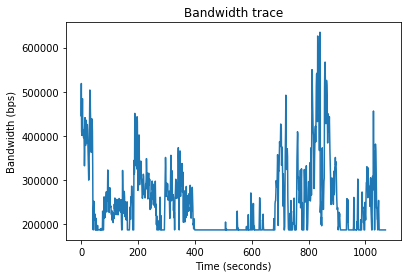

In [4]:
bw = tracesim_bandwidth.Bandwidth('./4G_log/report_bicycle_0002.log')
bw = tracesim_bandwidth.Bandwidth('./3G_log/test1.txt')
plt.plot(bw._trace)
plt.title('Bandwidth trace')
plt.xlabel('Time (seconds)')
plt.ylabel('Bandwidth (bps)')

In [5]:
#data
rad2 = [[55.825, 113.614, 1.527, 0.050, 0.811],
[63.524, 136.233, 1.527, 0.058, 0.633],
[73.984, 166.841, 1.527, 0.066, 0.425],
[33.000, 582.619, 8.101, 0.161, 1.000]]

#bwtrace=test1, RAD=3, predict 1 seconds in future
#Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
rad3 = [[36.714, 157.543, 2.853, 0.064, 0.948],
[43.857, 193.773, 2.853, 0.077, 0.825],
[53.143, 284.491, 2.853, 0.090, 0.575],
[33.000, 582.619, 8.101, 0.162, 1.000]]

#bwtrace=test1, RAD=4, predict 1 seconds in future
#Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
rad4 = [[33.762, 280.452, 4.582, 0.095, 0.987],
[38.095, 328.213, 4.582, 0.110, 0.907],
[46.365, 421.827, 4.582, 0.128, 0.688],
[33.000, 582.619, 8.101, 0.162, 1.000]]

rad5 = [[33.349, 357.062, 5.580, 0.114, 0.994],
[35.746, 406.637, 5.580, 0.125, 0.952],
[43.524, 515.409, 5.580, 0.147, 0.769],
[33.000, 582.619, 8.101, 0.162, 1.000]]

rad2, rad3, rad4, rad5 = np.array(rad2), np.array(rad3), np.array(rad4), np.array(rad5)
buff_count = np.array([rad2[:, 0], rad3[:, 0], rad4[:, 0], rad5[:, 0]])
buff_time = np.array([rad2[:, 1], rad3[:, 1], rad4[:, 1], rad5[:, 1]])
buff_start = np.array([rad2[:, 2], rad3[:, 2], rad4[:, 2], rad5[:, 2]])
bw_saved = np.array([1.0-rad2[:, 3]/rad2[:, 3][-1], 1.0-rad3[:, 3]/rad3[:, 3][-1], 1.0-rad4[:, 3]/rad4[:, 3][-1], 1.0-rad5[:, 3]/rad5[:, 3][-1]])
blank_ratio = np.array([1-rad2[:, 4], 1-rad3[:, 4], 1-rad4[:, 4], 1-rad5[:, 4]])


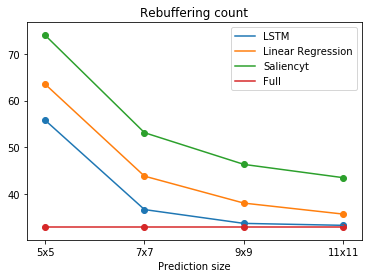

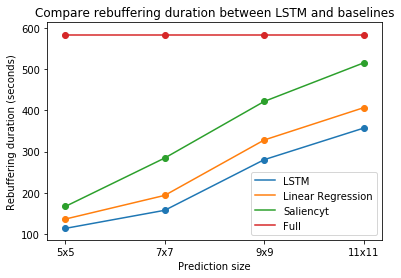

In [6]:
#VISULIZE BUFFER CONDITION: BUFFERING FREQUENCY

x = [2, 3, 4, 5]
xticks = ['5x5', '7x7', '9x9', '11x11']

plt.plot(x, buff_count[:, 0], label='LSTM')
plt.scatter(x, buff_count[:, 0])
plt.plot(x, buff_count[:, 1], label='Linear Regression')
plt.scatter(x, buff_count[:, 1])
plt.plot(x, buff_count[:, 2], label='Saliencyt')
plt.scatter(x, buff_count[:, 2])
plt.plot(x, buff_count[:, 3], label='Full')
plt.scatter(x, buff_count[:, 3])
plt.xlabel('Prediction size')
#plt.ylabel('Buffer freezing frequency')
plt.xticks(x, xticks)
plt.title('Rebuffering count')
plt.legend()

plt.figure()
#VISULIZE BUFFER CONDITION: BUFFERING DURATION


plt.plot(x, buff_time[:, 0], label='LSTM')
plt.scatter(x, buff_time[:, 0])
plt.plot(x, buff_time[:, 1], label='Linear Regression')
plt.scatter(x, buff_time[:, 1])
plt.plot(x, buff_time[:, 2], label='Saliencyt')
plt.scatter(x, buff_time[:, 2])
plt.plot(x, buff_time[:, 3], label='Full')
plt.scatter(x, buff_time[:, 3])
plt.xlabel('Prediction size')
plt.ylabel('Rebuffering duration (seconds)')
plt.xticks(x, xticks)
plt.title('Compare rebuffering duration between LSTM and baselines')
plt.legend()

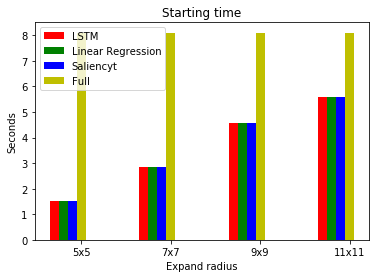

In [7]:
#VISULIZE BUFFER STARTING TIME

x = np.array([2, 3, 4, 5])
xticks = ['5x5', '7x7', '9x9', '11x11']

plt.bar(x-0.3, buff_start[:, 0], label='LSTM', width=0.1,color='r',align='center')
plt.bar(x-0.2, buff_start[:, 1], label='Linear Regression', width=0.1,color='g',align='center')
plt.bar(x-0.1, buff_start[:, 2], label='Saliencyt', width=0.1,color='b',align='center')
plt.bar(x, buff_start[:, 3], label='Full', width=0.1,color='y',align='center')
plt.xlabel('Expand radius')
plt.ylabel('Seconds')
plt.xticks(x, xticks)
plt.title('Starting time')
plt.legend()

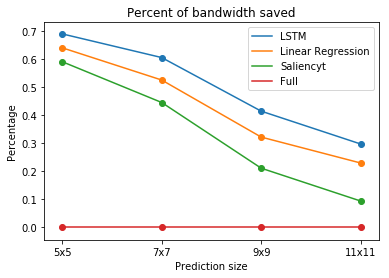

In [8]:
#VISULIZE BUFFER CONDITION: bw_saved
x = [2, 3, 4, 5]
xticks = ['5x5', '7x7', '9x9', '11x11']

plt.plot(x, bw_saved[:, 0], label='LSTM')
plt.scatter(x, bw_saved[:, 0])
plt.plot(x, bw_saved[:, 1], label='Linear Regression')
plt.scatter(x, bw_saved[:, 1])
plt.plot(x, bw_saved[:, 2], label='Saliencyt')
plt.scatter(x, bw_saved[:, 2])
plt.plot(x, bw_saved[:, 3], label='Full')
plt.scatter(x, bw_saved[:, 3])
plt.xlabel('Prediction size')
plt.ylabel('Percentage')
plt.xticks(x, xticks)
plt.title('Percent of bandwidth saved')
plt.legend()

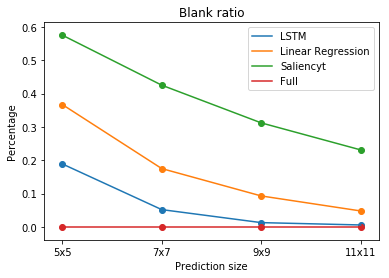

In [9]:
#VISULIZE BUFFER CONDITION: BLANK RATIO
x = [2, 3, 4, 5]
xticks = ['5x5', '7x7', '9x9', '11x11']


plt.plot(x, blank_ratio[:, 0], label='LSTM')
plt.scatter(x, blank_ratio[:, 0])
plt.plot(x, blank_ratio[:, 1], label='Linear Regression')
plt.scatter(x, blank_ratio[:, 1])
plt.plot(x, blank_ratio[:, 2], label='Saliencyt')
plt.scatter(x, blank_ratio[:, 2])
plt.plot(x, blank_ratio[:, 3], label='Full')
plt.scatter(x, blank_ratio[:, 3])
plt.xlabel('Prediction size')
plt.ylabel('Percentage')
plt.xticks(x, xticks)
plt.title('Blank ratio')
plt.legend()

In [10]:
idx = int(4.12345% len(sim._bandwidth._trace))
print idx, sim._bandwidth._trace[idx]

NameError: name 'sim' is not defined

In [11]:
#This code to measure quality experiences by users. 
#failed, too many times need to run, plan B, after this

In [12]:
bwtrace_path.split('/')[-1].replace('.txt', '')

RAD = 4
TOPIC = '3'
UID = 1


lstm_log = []
lnregr_log = []
sal_log = []
full_log = []
for TOPIC in ['1', '2']:
    bw_bound = sim._pred._tilesize_map_dict[TOPIC][:, :, :, 1].sum()
    for UID in range(8,10):
        print 'running for ', TOPIC, UID
        sim.run_quality(TOPIC, UID, model_name=sim._pred.LSTM, radius=RAD)
        lstm_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                        sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG]), np.mean(sim._log[sim._SSIM]), np.mean(sim._log[sim._FULL_SSIM])])
        
        sim.run_quality(TOPIC, UID, model_name=sim._pred.REGR, radius=RAD)
        lnregr_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                          sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG]), np.mean(sim._log[sim._SSIM]), np.mean(sim._log[sim._FULL_SSIM])])
        
        sim.run_quality(TOPIC, UID, model_name=sim._pred.SAL, radius=RAD)
        sal_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                       sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG]), np.mean(sim._log[sim._SSIM]), np.mean(sim._log[sim._FULL_SSIM])])
        
        #sim.run_full(TOPIC, UID)
        #full_log.append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
        #                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
        
lstm_log = np.array(lstm_log)
lnregr_log = np.array(lnregr_log)
sal_log = np.array(sal_log)
full_log = np.array(full_log)

pickle.dump([lstm_log, lnregr_log, sal_log, full_log], open('{}_{}_{}_psnr'.format(bwtrace_path, RAD, look_ahead), 'wb'))
print 'Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio'
for llog in [lstm_log, lnregr_log, sal_log, full_log]:
    print llog.mean(axis=0)

NameError: name 'sim' is not defined

In [ ]:
lstm_log = np.array(lstm_log)
lnregr_log = np.array(lnregr_log)
sal_log = np.array(sal_log)
full_log = np.array(full_log)

pickle.dump([lstm_log, lnregr_log, sal_log, full_log], open('ssim{}_{}_{}'.format(bwtrace_path, RAD, look_ahead), 'wb'))
print 'Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio'
for llog in [lstm_log, lnregr_log, sal_log, full_log]:
    print llog.mean(axis=0)

In [ ]:
#PSNR RESULT
#Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
#[40.500 404.572 4.475 0.095 0.987 38.864 39.088]
#[40.500 439.750 4.475 0.096 0.969 38.855 39.086]
#[57.500 574.137 4.475 0.136 0.549 38.605 39.080]

In [ ]:
bwtrace_path.split('/')[-1].replace('.txt', '')
bwtrace_name = bwtrace_path.split('/')[-1].replace('.txt', '')

RAD = 3
TOPIC = '3'
UID = 1

lstm_quallog = {}
lnregr_quallog = {}
sal_quallog = {}
full_quallog = {}

lstm_log = {}
lnregr_log = {}
sal_log = {}
full_log = {}

RAD = 4

#for RAD in [2, 3, 4, 5]:
    #bwscale = 50
bwtrace_list = ['./4G_log/report_car_0002.log',
                #'./4G_log/report_car_0004.log',
                './4G_log/report_bus_0002.log',
                #'./4G_log/report_bus_0004.log',
               './4G_log/report_foot_0001.log']
modelname_list = ['lstm', 'lnregr', 'sal', 'full']
bw_std = 2.5
bw_meanlist = [5.5, 8.0, 10.5, 13.0, 15.5, 18]
bwscalelist_str = '_'.join(map(str, bw_meanlist))
for scale_mean in bw_meanlist:#[1.0, 2.5, 5.5, 10.0, 15.0, 20.0]:
    scale_std = bw_std
    bwscale = scale_mean
    
    lstm_log[bwscale] = []
    lnregr_log[bwscale] = []
    sal_log[bwscale] = []
    full_log[bwscale] = []

    lstm_quallog[bwscale] = []
    lnregr_quallog[bwscale] = []
    sal_quallog[bwscale] = []
    full_quallog[bwscale] = []
    
    for bwtrace in bwtrace_list:
        sim._bandwidth = tracesim_bandwidth.Bandwidth(bwtrace, scale_mean=scale_mean, scale_std=scale_std)
        #sim._bandwidth.set_scale(bwscale)

        print 'running for bw{}'.format(bwscale)

        for TOPIC in ['0' ,'1']:#['0', '1', '2', '3', '4', '6', '7']:
            bw_bound = sim._pred._tilesize_map_dict[TOPIC][:, :, :, 1].sum()
            for UID in range(0, 3):#range(1, 10):
                print 'running for ', TOPIC, UID
                sim.run(TOPIC, UID, model_name=sim._pred.LSTM, radius=RAD)
                lstm_log[bwscale].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                lstm_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run(TOPIC, UID, model_name=sim._pred.REGR, radius=RAD)
                lnregr_log[bwscale].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                  sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                lnregr_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run(TOPIC, UID, model_name=sim._pred.SAL, radius=RAD)
                sal_log[bwscale].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                               sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                sal_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run_full(TOPIC, UID)
                full_log[bwscale].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                full_quallog[bwscale] += sim._log[sim._SSIM_LIST]
            
    lstm_log[bwscale] = np.array(lstm_log[bwscale])
    lnregr_log[bwscale] = np.array(lnregr_log[bwscale])
    sal_log[bwscale] = np.array(sal_log[bwscale])
    full_log[bwscale] = np.array(full_log[bwscale])

    #every bandwidth, save the whole information: what type of bw, rad, lookahead, scale
test_simulator_lib.save_log([lstm_log, lnregr_log, sal_log, full_log], bwtrace_name, RAD, look_ahead, bwscalelist_str)

#shuffle before write to disk
for quallog in [lstm_quallog, lnregr_quallog, sal_quallog, full_quallog]:
        for bwtrace in quallog:
            np.random.shuffle(quallog[bwtrace])    
#only retain top certain data (too many data)
limit=2000#only store first 1000 random data points
for quallog in [lstm_quallog, lnregr_quallog, sal_quallog, full_quallog]:
        for bwtrace in quallog:
            quallog[bwtrace] = quallog[bwtrace][:limit]
            
#output        

test_simulator_lib.save_quallog([lstm_quallog, lnregr_quallog, sal_quallog, full_quallog], modelname_list, RAD, look_ahead, bwscalelist_str)        

    #print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in lstm_quallog][:200])
    #print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in lnregr_quallog][:200])
    #print np.mean([headpred.viewport_overlap(t1, t2) for topic, ts, t1, t2 in sal_quallog][:200])





In [12]:
bwtrace_path.split('/')[-1].replace('.txt', '')
bwtrace_name = bwtrace_path.split('/')[-1].replace('.txt', '')

RAD=4
look_ahead = 16

bw_std = 2.5
bw_meanlist = [5.5, 8.0, 10.5, 13.0, 15.5, 18]
bwscalelist_str = '_'.join(map(str, bw_meanlist))

lstm_quallog, lnregr_quallog, sal_quallog, full_quallog = test_simulator_lib.load_quallog(bwtrace_name, RAD, look_ahead, bwscalelist_str)


ssim_lstm, ssim_lnregr, ssim_sal, ssim_full = [], [], [], []
ssim_list = [[], [], [], []]
for idx, quallog in enumerate([lstm_quallog, lnregr_quallog, sal_quallog, full_quallog]):
    print 'generating for models {}th'.format(idx)
    for bwtrace in sorted(quallog.keys()):
        ssim_list[idx] .append(test_simulator_lib.cal_psnr_log(quallog[bwtrace][:200], sim))
#qlstm = np.array(cal_pasnr_log(lstm_quallog[:200]))
#qregr = np.array(cal_psnr_log(lnregr_quallog[:200]))
#qsal = np.array(cal_psnr_log(sal_quallog[:200]))

test_simulator_lib.save_ssim(ssim_list, RAD, look_ahead, bwscalelist_str)

generating for models 0th
generating for models 1th
generating for models 2th
generating for models 3th


0.6629382506423658
0.6178220086483369
0.49818825366190833
0.512214623015095


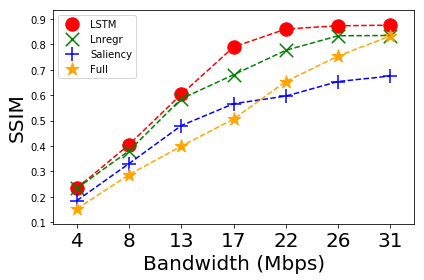

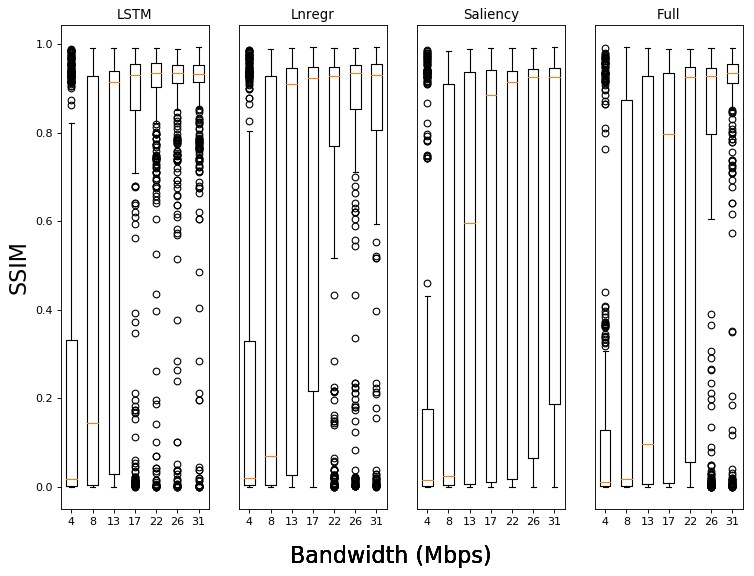

0.6629382506423658
0.6178220086483369
0.49818825366190833
0.512214623015095


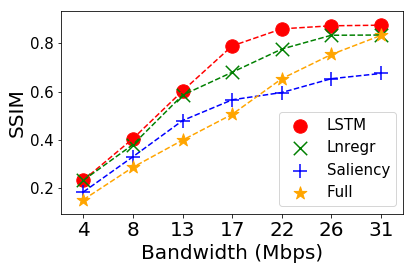

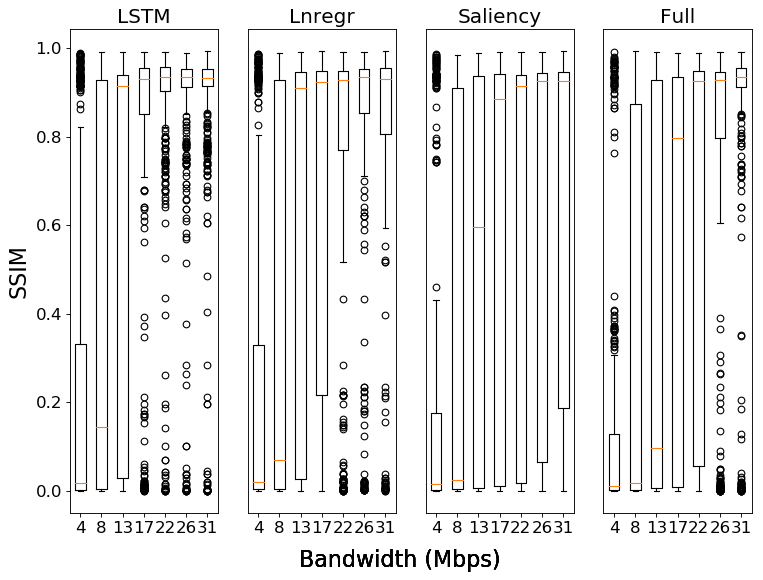

In [40]:
RAD=4
look_ahead = 16

bw_std = 3
bw_meanlist = [4.0, 8.5, 13.0, 17.5, 22.0, 26.5, 31.0]
scale_list = np.array([[bw_mean, bw_std] for bw_mean in bw_meanlist])
bwscalelist_str = '_'.join(map(str, bw_meanlist))

#ssim_list = pickle.load(open('./result/SSIM_rad4_look16'))
ssim_list = test_simulator_lib.load_ssim(RAD, look_ahead, bwscalelist_str)
color_list = ['red', 'green', 'blue', 'orange']
modelname_list = ['LSTM', 'Lnregr', 'Saliency', 'Full']


xticks = np.array(bw_meanlist, dtype=np.int)
x = np.arange(len(xticks))
marker_list = ['o', 'x', '+', '*']
for idx, imodel in enumerate(range(len(ssim_list))):
    y = []
    for jbw in range(len(ssim_list[0])):
        temp = ssim_list[imodel][jbw][:, 1].mean()
        y.append(temp)
    

    plt.plot(x, y, color=color_list[imodel], linestyle='--', )
    plt.scatter(x, y, color=color_list[imodel], label=modelname_list[imodel], s=180, marker=marker_list[idx])
    #plt.title('SSIM with different bandwidth for {}'.format(modelname_list[imodel]))
plt.xticks(x, xticks, fontsize=20)
plt.ylabel('SSIM', fontsize=20)
plt.xlabel('Bandwidth (Mbps)', fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('./figs/SSIM_plot.pdf', format='pdf', dpi=1000)

    
  

fig=plt.figure(figsize=(11, 8), dpi= 80, facecolor='w', edgecolor='k')  
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.xlabel('Bandwidth (Mbps)', fontsize=20)
for imodel in range(len(ssim_list)):
    plt.subplot(1, len(ssim_list), imodel+1)
    
    y = [ssim_list[imodel][jbw][:, 1].tolist() for jbw in range(len(ssim_list[0]))]#number of bw data points
    print np.mean(y)
    plt.boxplot(y)
    if imodel == 0: plt.ylabel('SSIM', fontsize=20)
    else: plt.yticks([])
    fig.text(0.5, 0.04, 'Bandwidth (Mbps)', ha='center', fontsize=20)
    plt.xticks(x+1, xticks)
    plt.title('{}'.format(modelname_list[imodel]))
    plt.savefig('./figs/SSIM_boxlot.pdf', format='pdf', dpi=1000)

    




In [25]:
plt.yticks.()

SyntaxError: invalid syntax (<ipython-input-25-4a3dffc92fb2>, line 1)

0.6729247414500308
0.625284493978129
0.47670063864732043
0.494444821778444


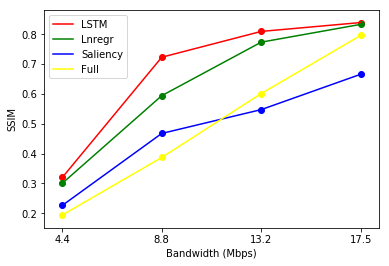

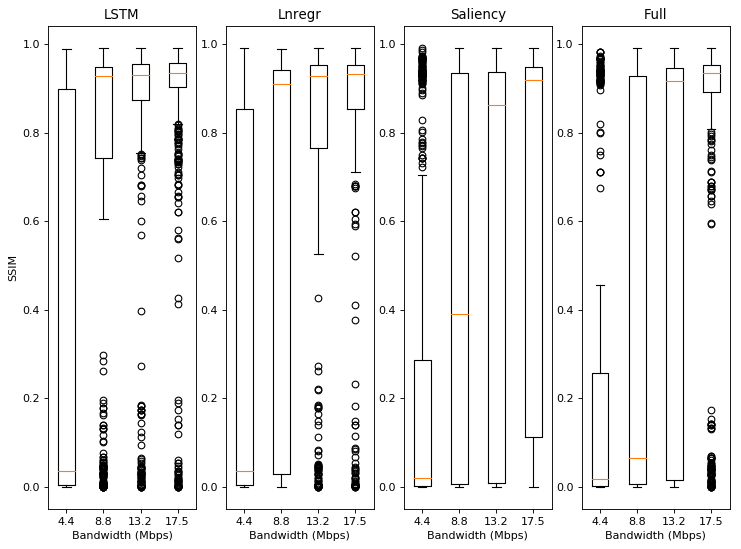

In [13]:
#RESULT SSIM for 1 BW trace

0.6729247414500308
0.625284493978129
0.47670063864732043
0.494444821778444


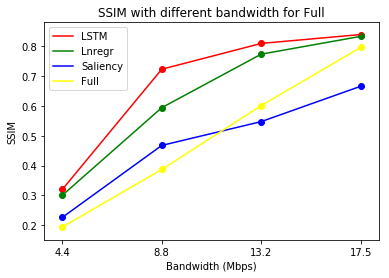

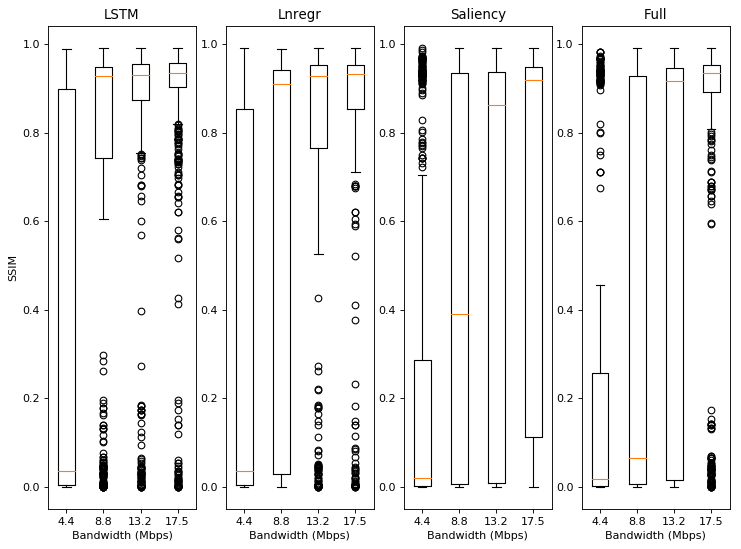

In [13]:
#load bwdict of log result
lstm_log, lnregr_log, sal_log, full_log = pickle.load(open('./result/test1_rad4_look16'))

In [ ]:
scale = scale_list[0]
dat_list = (lstm_log, lnregr_log, sal_log, full_log)
#stall_count, stall_duration, start_time, bwsaved, blankratio
idx = 0
x = np.arange(len(modelname_list))
y = [dat[scale][:, idx] for dat in dat_list]
def boxplot_log(dat_list, x, xticks):
    plt.boxplot(dat_list)
    plt.xticks(x+1, xticks)
boxplot_log(y, x, modelname_list)


In [ ]:
##RESULT OF PSNR & SSIM, with black & exception skip
#31.26842887291572 29.68901429158914 29.88672216750774
#0.30142831682102567 0.1521247532403662 0.15091755642415638


##result of PSNR, SSIM, no SSIM range, exception skip
#RAD=4, bwscale=25
38.13705206762921 37.88182530027026 36.59362402310609
0.892635401306853 0.8898498889002062 0.8011860808590728

##result of PSNR, SSIM, no SSIM range
#rad=4, bwscale=15, 3 users, 5 movies, with zeros
37.86438951725031 37.16645602155799 36.45769860110375
0.9271775755809939 0.9023435128927606 0.798445217452342

#rad=4, bwscale=5.5, 5 users, 5 movies, no zeros exception skipping SSIM
36.25426710048398 34.242546537388066 33.66063302366892
0.755720015072391 0.5921057106183393 0.5453502488298961

#rad= 4, bwscale=2.5, no zeros, 
32.32014843503807 30.65805768284339 31.056494739837333
0.4068307581210258 0.2760825247600477 0.31292261405975913



In [ ]:
#RERUN the exeperiment bwscale=1, RAD_LIST = [2, 3, 4, 5, FULL] to get result with plotbox
bwtrace_path.split('/')[-1].replace('.txt', '')
bwtrace_name = bwtrace_path.split('/')[-1].replace('.txt', '')

RAD = 3
TOPIC = '3'
UID = 1


lstm_log = {}
lnregr_log = {}
sal_log = {}
full_log = {}


bwtrace_list = ['./4G_log/report_car_0002.log',
                #'./4G_log/report_car_0004.log',
                #'./4G_log/report_bus_0002.log',
                #'./4G_log/report_bus_0004.log',
               './4G_log/report_foot_0001.log']
RAD_list = [2, 3, 4, 5]
radlist_str = '_'.join(map(str, RAD_list))
#bwscale = 1.5
#sim._bandwidth.set_scale(bwscale)
for RAD in RAD_list:
    lstm_log[RAD] = []
    lnregr_log[RAD] = []
    sal_log[RAD] = []
    full_log[RAD] = []
    
    for bwtrace in bwtrace_list:
        scale_mean = -1
        scale_std= -1
        bwscale = '{}_{}'.format(scale_mean, scale_std)
        sim._bandwidth = tracesim_bandwidth.Bandwidth(bwtrace, scale_mean=scale_mean, scale_std=scale_std)

        print 'running for bwtrace: {},  rad {}'.format(bwtrace, RAD)

        for TOPIC in ['0']:#['0', '1', '2', '3', '4', '6', '7', '8']:
            bw_bound = sim._pred._tilesize_map_dict[TOPIC][:, :, :, 1].sum()
            for UID in range(1):#range(1, 10):
                print 'running for ', TOPIC, UID
                sim.run(TOPIC, UID, model_name=sim._pred.LSTM, radius=RAD)
                lstm_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #lstm_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run(TOPIC, UID, model_name=sim._pred.REGR, radius=RAD)
                lnregr_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                  sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #lnregr_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run(TOPIC, UID, model_name=sim._pred.SAL, radius=RAD)
                sal_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                               sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #sal_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run_full(TOPIC, UID)
                full_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #full_quallog[bwscale] += sim._log[sim._SSIM_LIST]

    lstm_log[RAD] = np.array(lstm_log[RAD])
    lnregr_log[RAD] = np.array(lnregr_log[RAD])
    sal_log[RAD] = np.array(sal_log[RAD])
    full_log[RAD] = np.array(full_log[RAD])

#every bandwidth, save the whole information: what type of bw, rad, lookahead, scale

test_simulator_lib.save_log([lstm_log, lnregr_log, sal_log, full_log], "trash", radlist_str, look_ahead, bwscale)





running for bwtrace: ./4G_log/report_car_0002.log,  rad 2
running for  0 0
running for bwtrace: ./4G_log/report_foot_0001.log,  rad 2
running for  0 0
running for bwtrace: ./4G_log/report_car_0002.log,  rad 3
running for  0 0
running for bwtrace: ./4G_log/report_foot_0001.log,  rad 3
running for  0 0
running for bwtrace: ./4G_log/report_car_0002.log,  rad 4
running for  0 0
running for bwtrace: ./4G_log/report_foot_0001.log,  rad 4
running for  0 0
running for bwtrace: ./4G_log/report_car_0002.log,  rad 5
running for  0 0


12.924464285714286
[2.2790499999999785, 3.3480214285713874, 7.193971428571313, 0.0]
[0.3503843420485271, 0.2682726079529995, 0.06175191338016211, 0.0]
[0.10636275547775112, 0.1365916670039516, 0.21564318407570632, 0.0]
26.41839285714286
[4.21947857142851, 7.211071428571356, 15.492757142857348, 15.868285714285943]
[0.39756728740960234, 0.32161663683195074, 0.15030710857675986, 0.0]
[0.15326513427867658, 0.21754129515347098, 0.34190527448073227, 0.3351471097611709]
38.67482142857143
[44.24792142857321, 52.42170714285955, 70.10858571428885, 112.82285714286017]


/glob/intel-python/versions/2018u1/intelpython2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[0.48228750907721724, 0.4234741651101987, 0.2913640820213221, 0.0]
[0.5596493192499238, 0.6075022893903974, 0.6689375419381731, 0.7720856183558433]
18.158392857142857
[5.282621428571363, 7.47265714285711, 13.826392857142995, 9.848857142857355]
[0.38055106002012556, 0.29956129466625886, 0.1034714125666937, 0.0]
[0.1723780129642945, 0.2171976415308133, 0.3106798077915563, 0.20371383746202684]


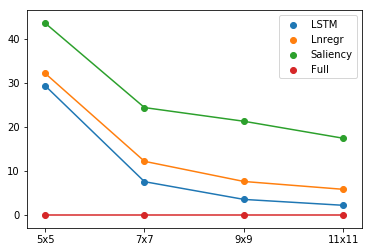

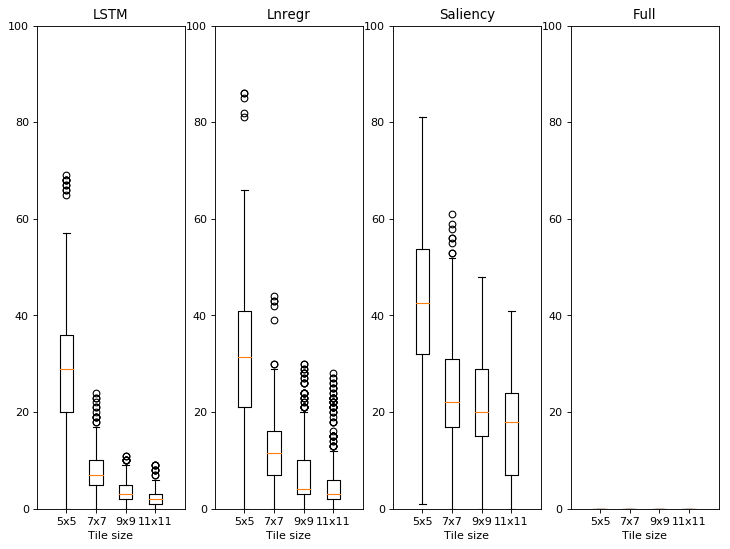

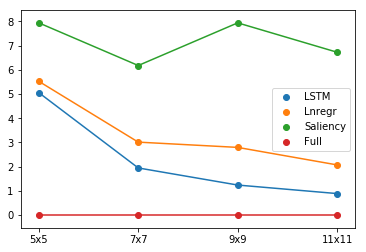

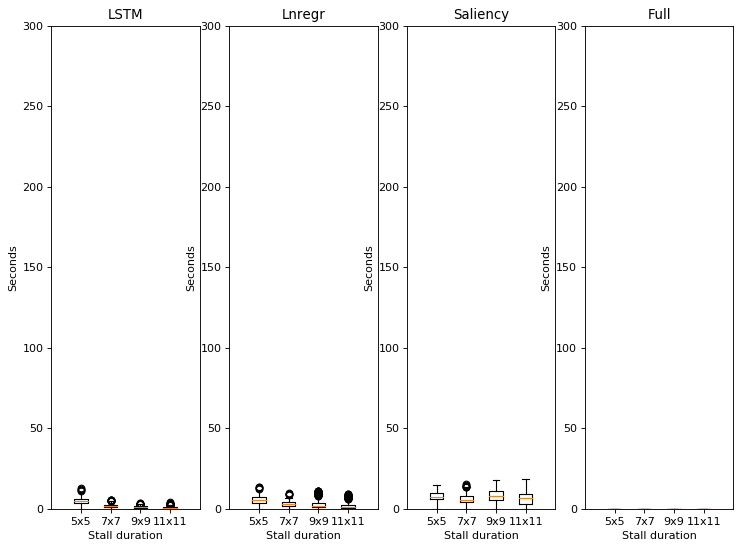

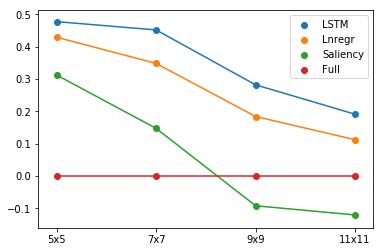

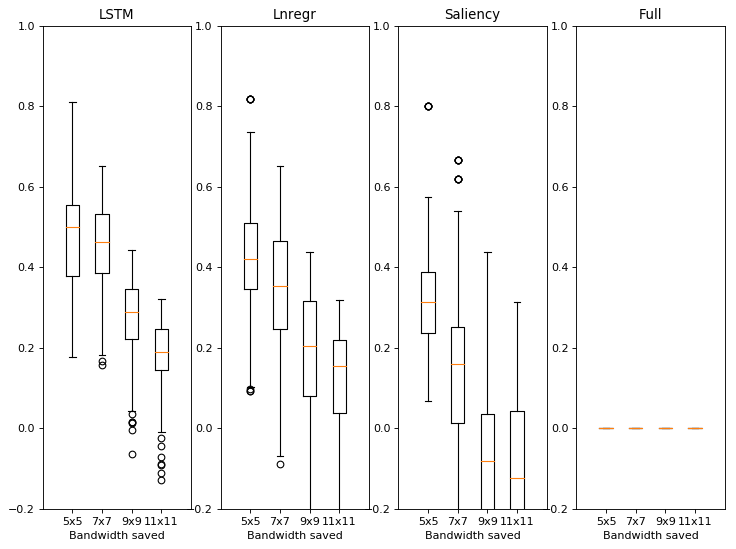

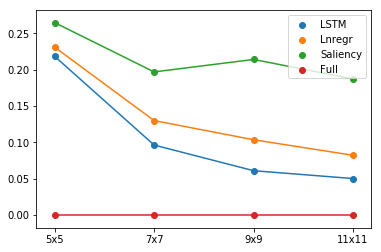

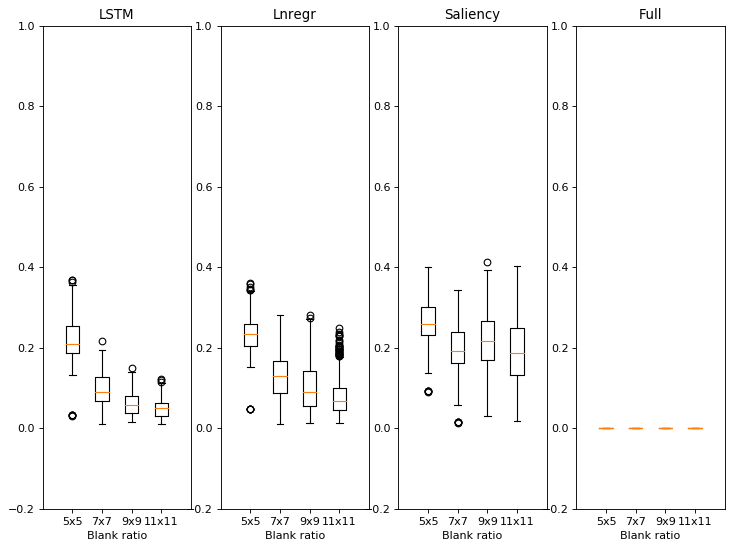

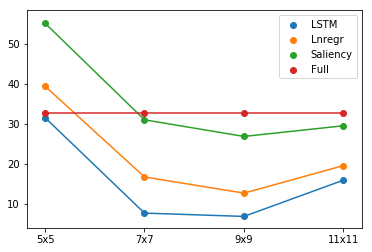

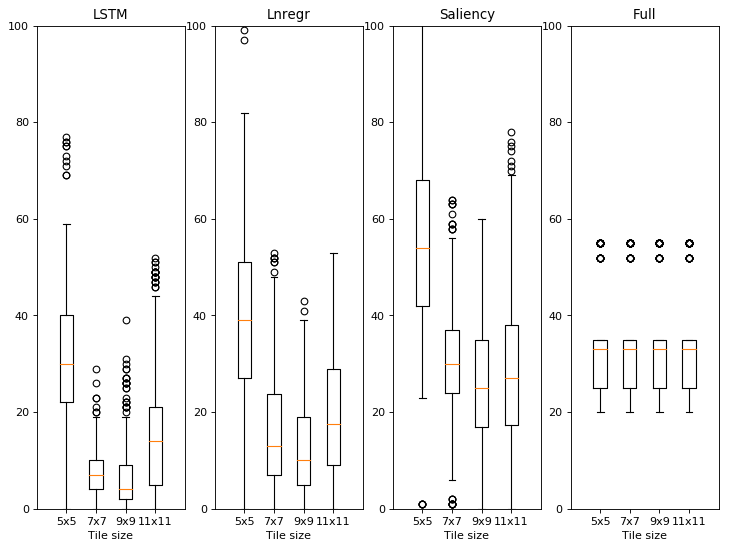

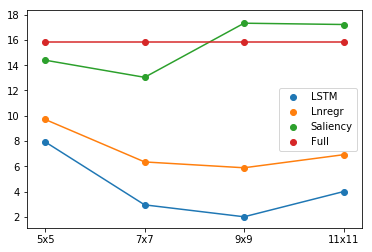

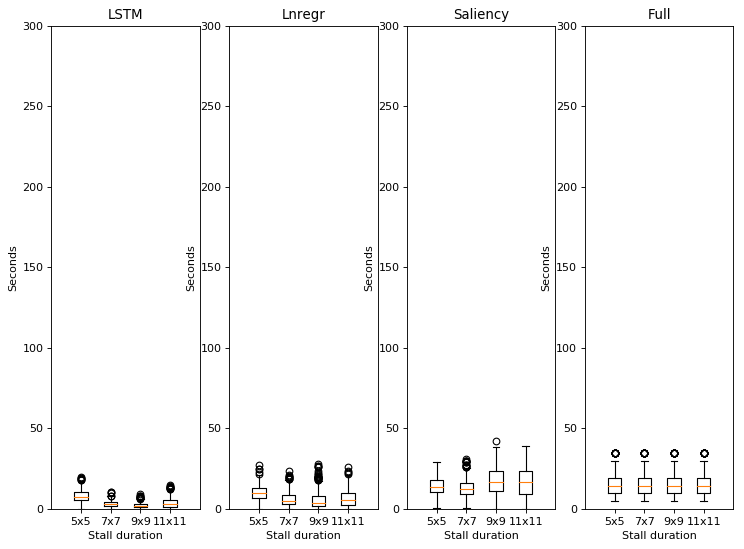

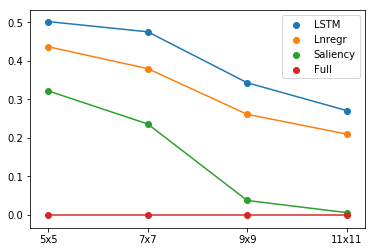

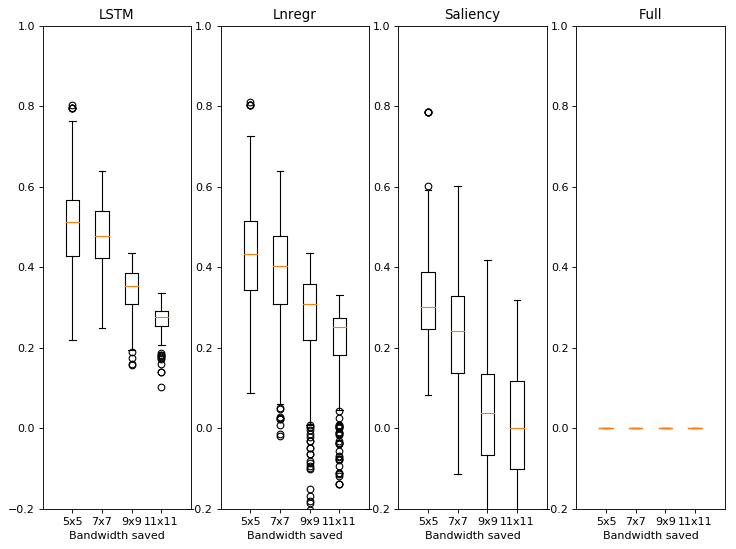

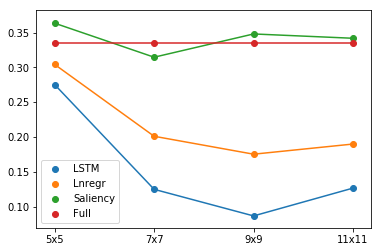

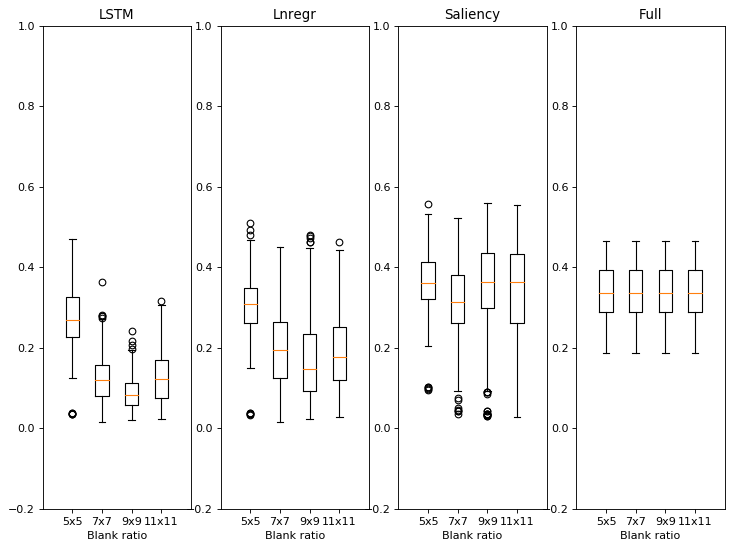

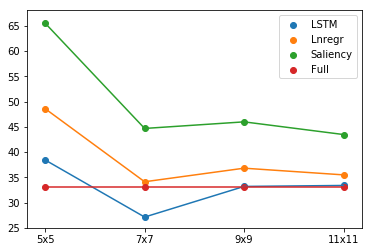

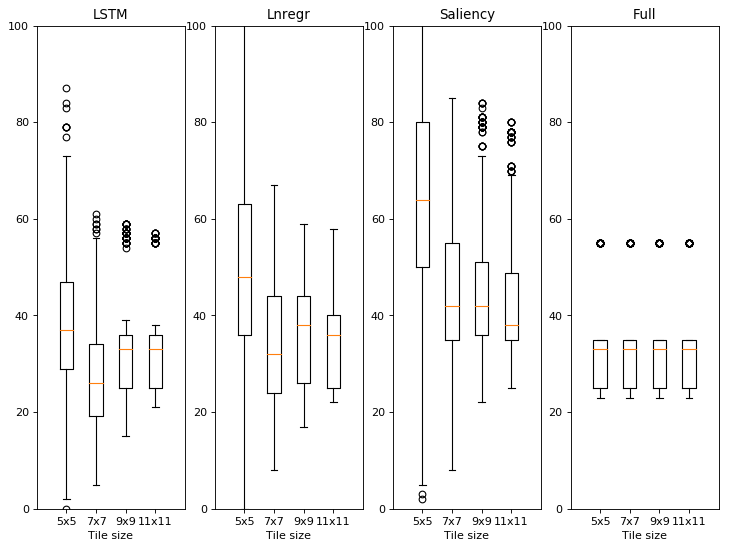

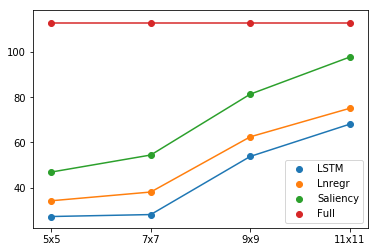

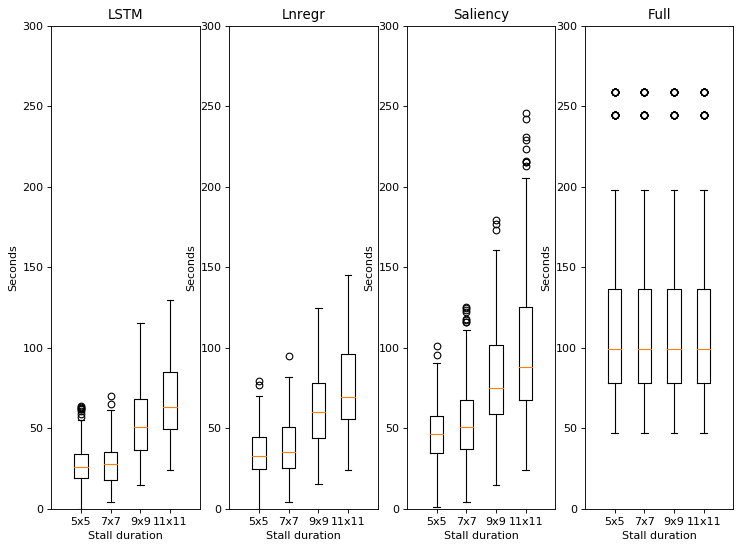

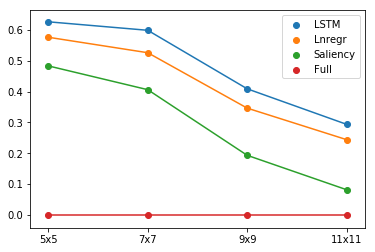

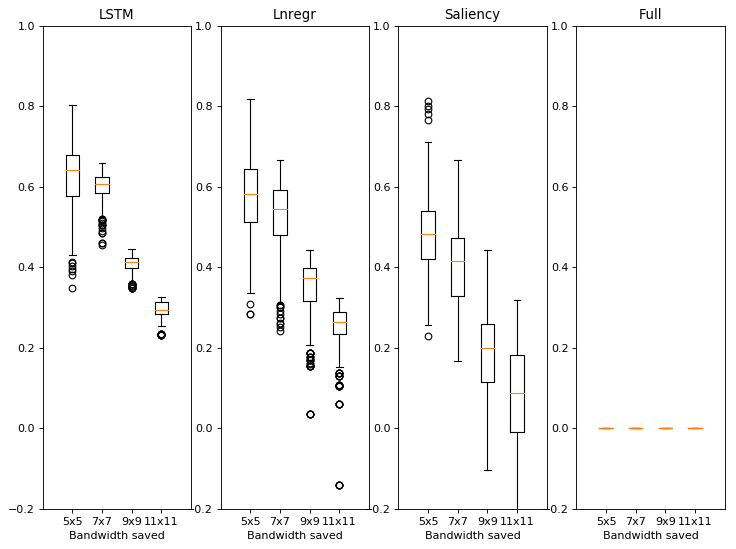

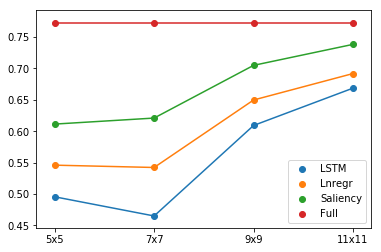

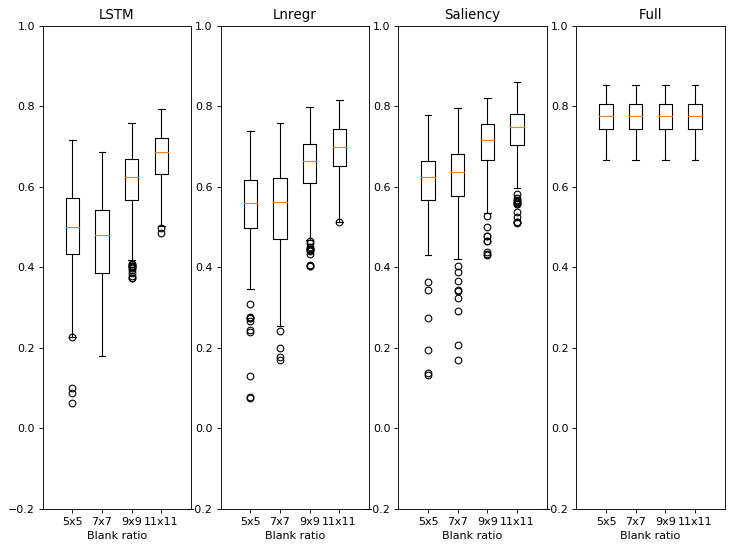

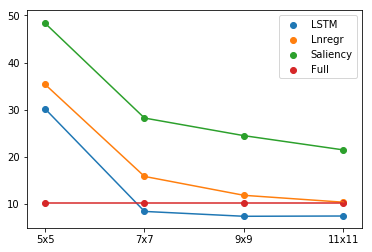

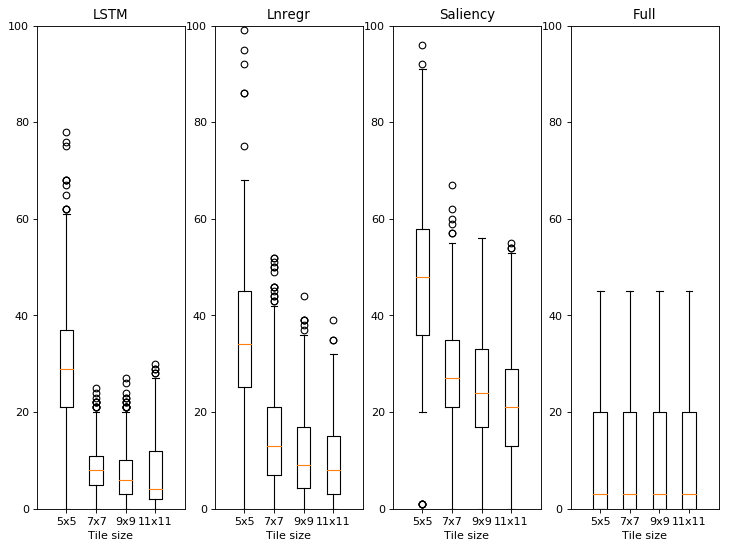

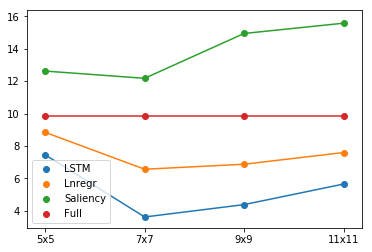

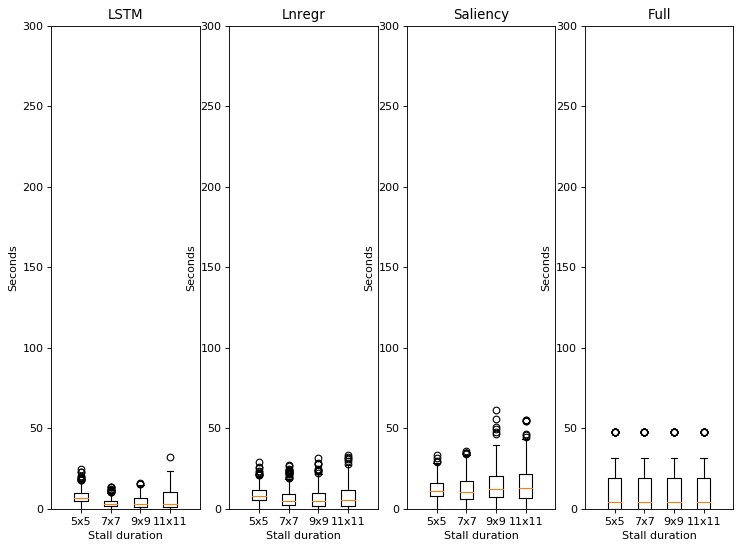

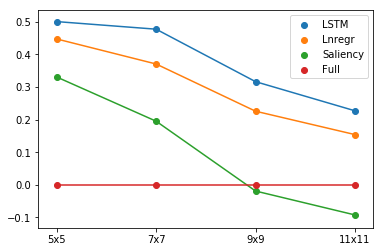

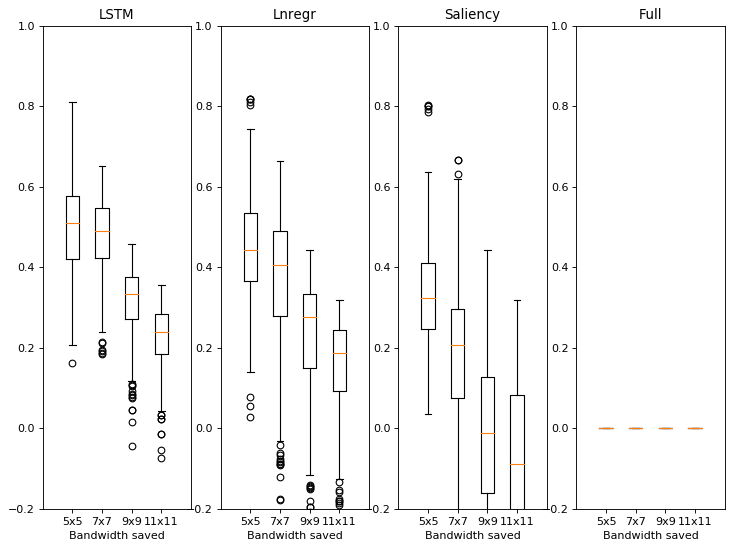

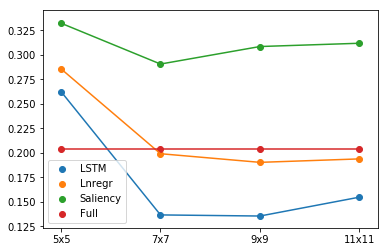

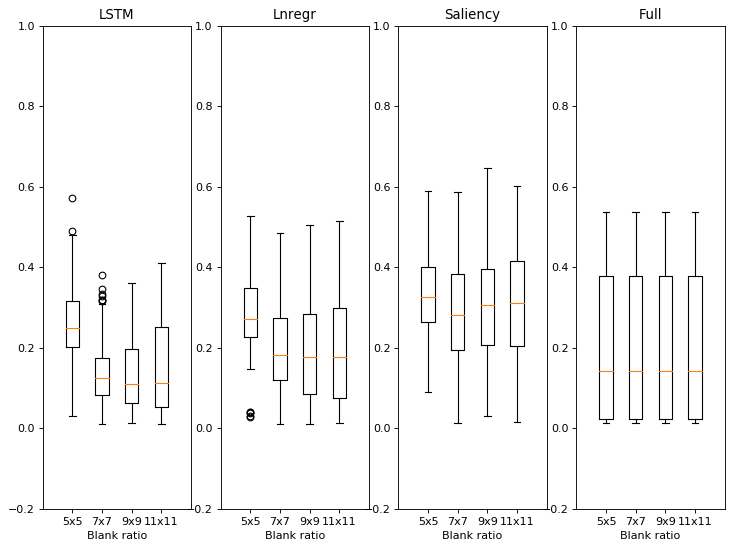

In [2]:
def visualize_log(log_list, x, xticks, xlabel, modelname_list, bwlevel=8.0):
    lstm_log, lnregr_log, sal_log, full_log = log_list
    col = 0#showing just the stalling count
    y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
    test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, xlabel=xlabel, ylabel='', axis=[0, 5, 0, 100])   
    print np.mean(y_list)

    col = 1#showing just the stalling duration
    y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
    test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, xlabel=xlabel_list[col], ylabel='Seconds', axis=[0, 5, 0, 300])  
    print [np.mean(y) for y in y_list]
    
    col = 3#showing just the stalling duration
    y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
    y_list2 = 1 - y_list/y_list[-1].max(axis=0)
    test_simulator_lib.plot_log(plt, x, xticks, y_list2, modelname_list,  xlabel=xlabel_list[col], ylabel='', axis=[0, 5, -0.2, 1])  
    print [np.mean(y) for y in y_list2]
    
    col = 4#showing just the blank ratio
    y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
    y_list2 = 1-y_list
    if bwlevel > 44.0: y_list2[-1] = y_list2[-1]*0.0
    test_simulator_lib.plot_log(plt, x, xticks, y_list2, modelname_list,  xlabel=xlabel_list[col], ylabel='', axis=[0, 5, -0.2, 1])  
    print [np.mean(y) for y in y_list2]

look_ahead = 16
scale_mean = 44.5#-1#-1.0#8.0#21.5#8.0
scale_std = 4.5#-1#-1.0#2.5#4.5#2.5
bwscale = '{}_{}'.format(scale_mean, scale_std)
RAD_list = [2, 3, 4, 5]
radlist_str = '_'.join(map(str, RAD_list))
lstm_log, lnregr_log, sal_log, full_log = test_simulator_lib.load_log("test1", radlist_str, look_ahead, bwscale)

xlabel_list=['Stall count', 'Stall duration', 'Start time', 'Bandwidth saved', 'Blank ratio']
xticks=['5x5', '7x7', '9x9', '11x11']
x = np.arange(len(xticks))
xlabel='Tile size'
modelname_list = ['LSTM', 'Lnregr', 'Saliency', 'Full']
log_list = lstm_log, lnregr_log, sal_log, full_log
visualize_log(log_list, x, xticks, xlabel, modelname_list, bwlevel=44.5)

scale_mean = 22.5#-1#-1.0#8.0#21.5#8.0
scale_std = 4.5#-1#-1.0#2.5#4.5#2.5
bwscale = '{}_{}'.format(scale_mean, scale_std)
lstm_log, lnregr_log, sal_log, full_log = test_simulator_lib.load_log("test1", radlist_str, look_ahead, bwscale)
log_list = lstm_log, lnregr_log, sal_log, full_log
visualize_log(log_list, x, xticks, xlabel, modelname_list, bwlevel=22.5)

scale_mean = 8.5#-1#-1.0#8.0#21.5#8.0
scale_std = 4.5#-1#-1.0#2.5#4.5#2.5
bwscale = '{}_{}'.format(scale_mean, scale_std)
lstm_log, lnregr_log, sal_log, full_log = test_simulator_lib.load_log("test1", radlist_str, look_ahead, bwscale)
log_list = lstm_log, lnregr_log, sal_log, full_log
visualize_log(log_list, x, xticks, xlabel, modelname_list, bwlevel=22.5)



scale_mean = -1.0#-1.0#8.0#21.5#8.0
scale_std = -1.0#-1.0#2.5#4.5#2.5
bwscale = '{}_{}'.format(scale_mean, scale_std)
lstm_log, lnregr_log, sal_log, full_log = test_simulator_lib.load_log("test1", radlist_str, look_ahead, bwscale)
log_list = lstm_log, lnregr_log, sal_log, full_log
visualize_log(log_list, x, xticks, xlabel, modelname_list, bwlevel=0)

In [32]:
print y_list, y_list[-1].max(axis=0), 
print y_list/y_list[-1].max(axis=0)

[[[0.075 0.057 0.069 0.057 0.044 0.040 0.046 0.034]
  [0.082 0.076 0.079 0.073 0.047 0.050 0.048 0.043]
  [0.124 0.120 0.120 0.116 0.070 0.070 0.071 0.073]
  [0.156 0.147 0.142 0.142 0.084 0.082 0.087 0.082]]

 [[0.095 0.075 0.092 0.076 0.046 0.043 0.049 0.041]
  [0.126 0.123 0.115 0.104 0.052 0.050 0.056 0.050]
  [0.170 0.169 0.166 0.158 0.072 0.075 0.077 0.070]
  [0.195 0.181 0.186 0.177 0.084 0.090 0.090 0.083]]

 [[0.093 0.084 0.089 0.058 0.054 0.054 0.061 0.049]
  [0.112 0.096 0.110 0.089 0.072 0.078 0.076 0.064]
  [0.165 0.147 0.143 0.130 0.118 0.108 0.110 0.093]
  [0.181 0.164 0.150 0.155 0.137 0.132 0.135 0.107]]

 [[0.209 0.209 0.209 0.209 0.122 0.122 0.122 0.122]
  [0.209 0.209 0.209 0.209 0.122 0.122 0.122 0.122]
  [0.209 0.209 0.209 0.209 0.122 0.122 0.122 0.122]
  [0.209 0.209 0.209 0.209 0.122 0.122 0.122 0.122]]] [0.209 0.209 0.209 0.209 0.122 0.122 0.122 0.122] [[[0.359 0.273 0.331 0.271 0.365 0.325 0.377 0.283]
  [0.391 0.361 0.379 0.347 0.390 0.414 0.394 0.355]
  [0.5

In [7]:
bwtrace_list = ['./4G_log/report_car_0002.log', './4G_log/report_bus_0004.log']
for bwtrace in bwtrace_list:
    sim._bandwidth = tracesim_bandwidth.Bandwidth(bwtrace, scale_mean=6.0, scale_std=2.0)